In [1]:
# Make code toggle-able for easier review.
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<i>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a></i>.''')

# Load & Check Data

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import math
from sklearn import linear_model
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm


import warnings

from IPython.display import display

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Acquire, load, and preview the data.
crime = pd.read_csv('/Users/guest/Dropbox/Education/Thinkful/Unit 2/L4 - Linear Regression/ny_crime_clean.csv')
display(crime.head())

,city,population_wins,population_sq,murder_cat,robbery_cat,property_crime_wins
0,Adams Village,1861.000,3463321.000,0,0,12.000
1,Addison Town and Village,2577.000,6640929.000,0,0,24.000
2,Akron Village,2846.000,8099716.000,0,0,16.000
3,Albany,57559.000,3313038481.000,1,1,1391.000
4,Albion Village,6388.000,40806544.000,0,1,223.000


<hr>
# Instantiate, Fit, and Inspect Model

In [4]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = crime['property_crime_wins'].values.reshape(-1, 1)
X = crime[['population_wins','population_sq','murder_cat', 'robbery_cat']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[  1.16919705e-02   1.49358699e-07   8.81913051e+01   9.69363363e+01]]

Intercept: 
 [-11.66680196]

R-squared:
0.823536400001


<hr>
# Check Assumptions

### Assumption one: linear relationship

In [5]:
# Set variables
X_plot = ['population_wins','population_sq','murder_cat', 'robbery_cat']
Y_plot = 'property_crime_wins'

In [6]:
# Define the scatterplot function
def plot_scat(frame, X, Y):
    fig, axes = plt.subplots(1, len(X), figsize=(14,3))
    for var in X:
        idx = X.index(var)
        sns.regplot(y=frame[Y], x=frame[var], ax=axes[idx])

###### Scatterplots
All variables appear to have a linear relationship with property crime.

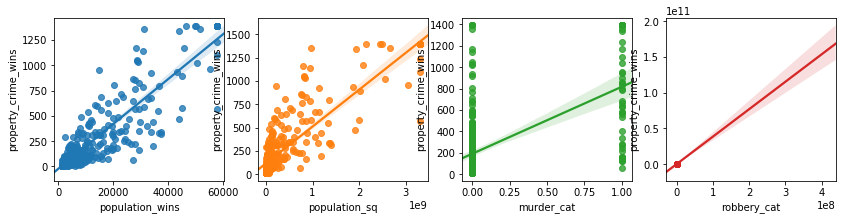

In [7]:
plot_scat(crime, X_plot, Y_plot)

##### Correlation Heatmap
All variables correlate with property crime.

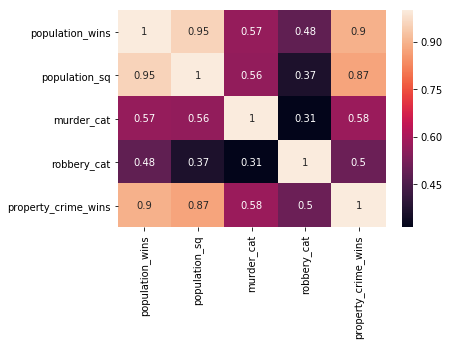

In [8]:
sns.heatmap(crime.corr(), annot=True)
plt.show()

###### Significance Testing
All variables have a significant relationship with property crime.

In [9]:
for var in X_plot:
    model = sm.OLS(crime[Y_plot], crime[var]).fit()
    predictions = model.predict(crime[var])
    print('\n\n' + var)
    print(model.summary())




population_wins
                             OLS Regression Results                            
Dep. Variable:     property_crime_wins   R-squared:                       0.872
Model:                             OLS   Adj. R-squared:                  0.872
Method:                  Least Squares   F-statistic:                     2374.
Date:                 Sat, 07 Jul 2018   Prob (F-statistic):          2.97e-157
Time:                         14:14:18   Log-Likelihood:                -2275.8
No. Observations:                  348   AIC:                             4554.
Df Residuals:                      347   BIC:                             4557.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
population_win

__SUMMARY:__ Linear relationships exist between each feature and the dependent variable.<br>

<hr>
### Assumption two: multivariate normality

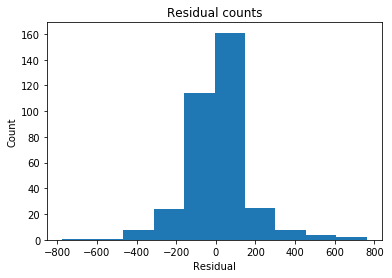

In [10]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = crime['property_crime_wins']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [11]:
# Define the histogram plotting function
def plot_hists(frame, vs):
    fig, axes = plt.subplots(1, len(vs), figsize=(14,3))
    for var in vs:
        idx = vs.index(var)
        frame.hist(var, ax=axes[idx])

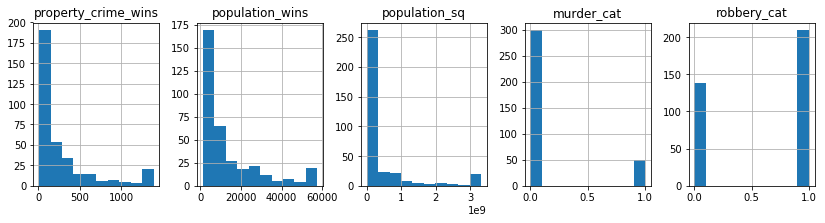

In [12]:
variables = ['property_crime_wins','population_wins','population_sq','murder_cat', 'robbery_cat']
plot_hists(crime, variables)

__SUMMARY:__ This looks okay – the distribution of residual counts is fairly normal.<br>

<hr>
### Assumption three: homoscedasticity

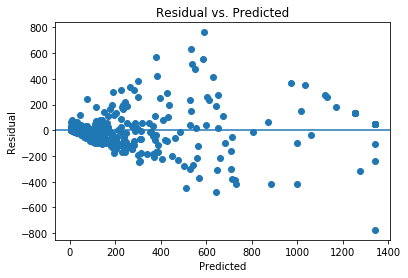

In [13]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

__SUMMARY:__ This looks pretty heteroscedastic and I don't know the best way to fix it – do you have any advice?<br>

<hr>
### Assumption four: low multicollinearity


Not a big concern – all I'm aiming for is predictive power.

<hr>
# Revisiting the model

In [14]:
# Create a function that checks for normality given transformations

from scipy.stats import normaltest

def transformation_test(data, variable, alpha=0.05):    
    def untransformed(x):return x
    def square(x):return x**2
    def cube(x):return x**3
    def recip(x):return 1/x

    tests = {'no_transformation':untransformed,
             'squared_data':square,
             'cubed_data':cube,
             'square_root':np.sqrt,
             'cube_root':np.cbrt,
             'log':np.log,
             'reciprocal':recip}
    
    test_df = pd.DataFrame(columns=list(tests))
    
    header_length = 44 + len(variable)
    header = '*' * header_length
    
    print('{}\n*** Testing transformations of variable {} ***\n{}\n'.format(header, variable, header,))
    
    for element in tests:
        test_df[element] = data[variable].apply(lambda x: tests[element](x))
        stat, p = normaltest(test_df[element])
        print('Statistics=%.3f, p=%.3f, alpha=%.3f' % (stat, p, alpha))
        if p > alpha:
            print('{}; looks normal (fail to reject H0)\n'.format(element))
        else:
            print('{}; sample does not look normal (reject H0)\n'.format(element))
                     
    plot_hists(test_df,list(tests))
        

##### Test transformations for property crime

***************************************************************
*** Testing transformations of variable property_crime_wins ***
***************************************************************

Statistics=124.836, p=0.000, alpha=0.050
no_transformation; sample does not look normal (reject H0)

Statistics=204.148, p=0.000, alpha=0.050
squared_data; sample does not look normal (reject H0)

Statistics=237.258, p=0.000, alpha=0.050
cubed_data; sample does not look normal (reject H0)

Statistics=48.033, p=0.000, alpha=0.050
square_root; sample does not look normal (reject H0)

Statistics=28.059, p=0.000, alpha=0.050
cube_root; sample does not look normal (reject H0)

Statistics=37.035, p=0.000, alpha=0.050
log; sample does not look normal (reject H0)

Statistics=142.103, p=0.000, alpha=0.050
reciprocal; sample does not look normal (reject H0)



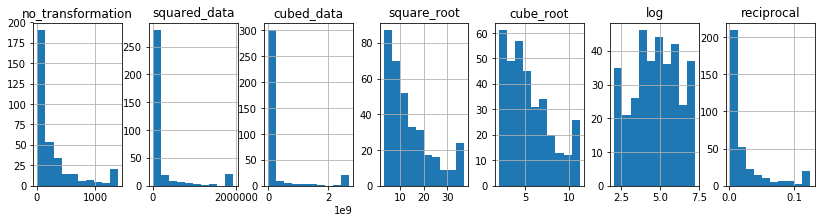

In [15]:
transformation_test(crime, 'property_crime_wins')

###### Test transformations for population

***********************************************************
*** Testing transformations of variable population_wins ***
***********************************************************

Statistics=104.238, p=0.000, alpha=0.050
no_transformation; sample does not look normal (reject H0)

Statistics=195.868, p=0.000, alpha=0.050
squared_data; sample does not look normal (reject H0)

Statistics=238.082, p=0.000, alpha=0.050
cubed_data; sample does not look normal (reject H0)

Statistics=40.275, p=0.000, alpha=0.050
square_root; sample does not look normal (reject H0)

Statistics=30.495, p=0.000, alpha=0.050
cube_root; sample does not look normal (reject H0)

Statistics=79.987, p=0.000, alpha=0.050
log; sample does not look normal (reject H0)

Statistics=52.830, p=0.000, alpha=0.050
reciprocal; sample does not look normal (reject H0)



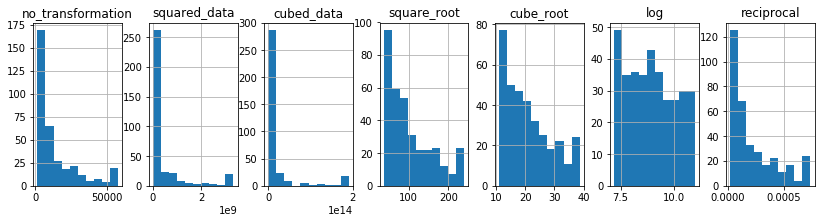

In [16]:
transformation_test(crime, 'population_wins')

None of the transformation I've tried here make the data normal. I suspect this has to do with __(1)__ the continued existence of outliers (meaning I should revisit my winsoring from the previous assignment) & __(2)__ the fact that the distribution of this data just isn't normal.

Log transformations provided the closest approximation of a normal distribution, so I'm going to run the model again with logged continuous variables.

In [17]:
crime['pop_log'] = crime['population_wins'].apply(lambda x: np.log(x))
crime['pop_sq_log'] = crime['population_sq'].apply(lambda x: np.log(x))
crime['prop_crime_log'] = crime['property_crime_wins'].apply(lambda x: np.log(x))

In [18]:
# Instantiate and fit our model.
regr2 = linear_model.LinearRegression()
Y2 = crime['prop_crime_log'].values.reshape(-1, 1)
X2 = crime[['pop_log','pop_sq_log','murder_cat', 'robbery_cat']]
regr2.fit(X2, Y2)

# Inspect the results.
print('\nCoefficients: \n', regr2.coef_)
print('\nIntercept: \n', regr2.intercept_)
print('\nR-squared:')
print(regr2.score(X2, Y2))


Coefficients: 
 [[ 0.17468209  0.34936418  0.24914208  0.88073477]]

Intercept: 
 [-3.64101462]

R-squared:
0.812351105091


The transformations slightly reduced the model's R squared, but substantially decreased the intercept - compare to the original model.

In [19]:
# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[  1.16919705e-02   1.49358699e-07   8.81913051e+01   9.69363363e+01]]

Intercept: 
 [-11.66680196]

R-squared:
0.823536400001


###### Examine multivariate normality

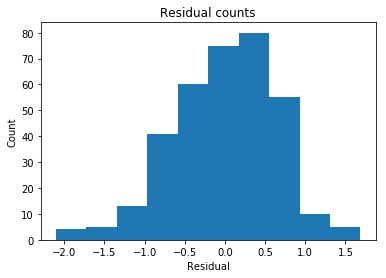

In [20]:
# Extract predicted values.
predicted2 = regr2.predict(X2).ravel()
actual2 = crime['prop_crime_log']

# Calculate the error, also called the residual.
residual2 = actual2 - predicted2

# This looks a bit concerning.
plt.hist(residual2)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

As expected, the distribution of residual counts is more normal after the transformations than it was before them.

###### Examine scedasticity 

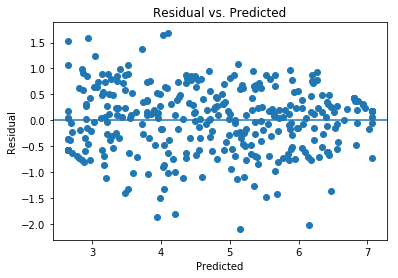

In [21]:
plt.scatter(predicted2, residual2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

The model appears to be considerably more scedastic after transformations as well.